In [1]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="1,3,6,7"

In [2]:
import sys
import torch
import pandas as pd
import numpy as np
import random 
from torch.utils.data import DataLoader
import torch.nn as nn
import misc_title

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [4]:
sys.path.insert(0,'../src_title/')
import config, dataset, model, engine, utils, model_parameters

In [5]:
def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    
set_seed(7) 

In [6]:
df_train, df_test = utils.split_data() ## Read the data 

In [7]:
## Create the data Loaders

train_dataset = dataset.FakeNewsDataset(df_train)

## using padding
train_data_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, collate_fn=dataset.MyCollate())



val_dataset = dataset.FakeNewsDataset(df_test)

## using padding
val_data_loader = DataLoader(val_dataset, batch_size=config.EVAL_BATCH_SIZE,
                        shuffle=True, collate_fn=dataset.MyCollate())

In [9]:
## to get component wise loss
def sim_loss(x, y):
    
    ## Create centroid (mean along dim=1 as x=(batch, nb_components, mulimodal_space_dim))
    centroid = torch.mean(x, dim=1, keepdim=True)

    centroid = centroid.repeat(1, x.size(1), 1)

    y = y.unsqueeze(1).repeat(1, x.size(1))

    batch_size = x.shape[0]

    # Squash samples and timesteps into a single axis
    x_reshape = x.contiguous().view(-1, x.size(-1))  # (b_s * num_components, latent_dim)

    centroid_reshape = centroid.contiguous().view(-1, centroid.size(-1))  # (b_s * num_components, latent_dim)
    
    ## Calculate distance of each component from the centroid
    dist_mat = config.PDIST(x_reshape, centroid_reshape).view(batch_size, -1)

    total_loss = torch.mean(dist_mat, dim=1)

    return total_loss 

In [10]:
EXP_NAME = "cleaned_GC_padding_title_exp2_saved"
MODEL_PATH = f'/media/nas_mount/Shivangi/mudit/log/saved_model/{EXP_NAME}.pt'

## Either run the model again or read csv file 

In [8]:
## Set the device and initialize the model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.Multiple_Images_Model()

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

model = model.to(device)

Using 4 GPUs


/home/shivangi/.conda/envs/fakenews/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 0 which
    has less than 75% of the memory or cores of GPU 3. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [11]:
loaded_state_dict = torch.load(MODEL_PATH,  map_location=device)

In [12]:
model.load_state_dict(loaded_state_dict)

<All keys matched successfully>

In [13]:
df_space, df_mean = misc_title.create_multimodal_space_df(model_parameters.MULTIMODAL_SPACE_DIM)
df_space, df_mean = misc_title.create_space(df_space, df_mean, model, train_data_loader, sim_loss, device)

 13%|█▎        | 351/2798 [01:23<08:41,  4.70it/s]/home/shivangi/.conda/envs/fakenews/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 2798/2798 [11:05<00:00,  4.20it/s]


## Read the precomputed vectors 

In [14]:
# df_mean.to_csv(f'./{EXP_NAME}_df_mean.csv')
# df_space.to_csv(f'./{EXP_NAME}_df_space.csv')
df_mean = pd.read_csv(f'./{EXP_NAME}_df_mean.csv')
df_space = pd.read_csv(f'./{EXP_NAME}_df_space.csv')

## RQ

In [15]:
df_mean.head()

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_121,col_122,col_123,col_124,col_125,col_126,col_127,col_128,cluster_dist,label
0,0.493291,-0.493362,-0.494764,-0.498001,-0.490539,0.498433,0.497630,0.498696,0.492404,0.499456,...,-0.489237,0.490467,0.496391,-0.490254,-0.496081,0.485162,-0.499207,0.493585,0.844257,1.0
1,0.493062,-0.491021,-0.494396,-0.490890,-0.496960,0.454738,0.473202,0.490439,0.477056,0.489277,...,-0.495543,0.479488,0.491666,-0.459914,-0.465118,0.499886,-0.468757,0.498032,1.538713,1.0
2,0.574186,-0.573332,-0.575694,-0.571387,-0.546984,0.529135,0.574580,0.569928,0.551385,0.577279,...,-0.551223,0.574398,0.577078,-0.570773,-0.562306,0.540707,-0.566151,0.569434,1.383575,1.0
3,0.499504,-0.490047,-0.488239,-0.486481,-0.492733,0.448529,0.493483,0.476468,0.455538,0.492540,...,-0.495376,0.491194,0.494277,-0.449381,-0.471955,0.495524,-0.458139,0.491732,1.515467,1.0
4,0.574046,-0.574816,-0.575667,-0.572623,-0.577175,0.576202,0.564641,0.565804,0.567391,0.576080,...,-0.575939,0.576350,0.575770,-0.574531,-0.569145,0.564645,-0.575086,0.569040,0.777662,0.0


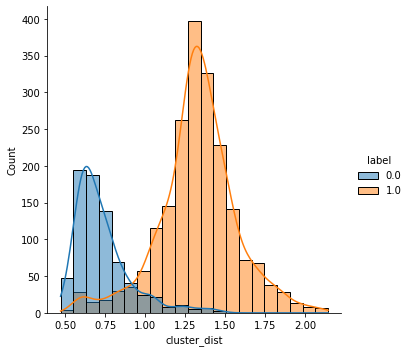

In [16]:
sns.displot(data=df_mean, x="cluster_dist", hue="label",kde=True)

## RQ

In [17]:
## Prepare input as the multimodal vectors for t-SNE plots and further analysis
X = df_mean[['col_'+str(i) for i in range(1,model_parameters.MULTIMODAL_SPACE_DIM+1)]].to_numpy()
Y_hue = df_mean['label'].to_numpy()
clust_size = df_mean['cluster_dist'].to_numpy()
nb_components = 2

In [18]:
# X_2d = misc_title.plot_bubbles(X, clust_size, Y_hue, nb_components)

## RQ 

In [82]:
df_dist = misc_title.create_dist_df(df_space, df_mean, model_parameters.MULTIMODAL_SPACE_DIM)

  0%|          | 0/2798 [00:00<?, ?it/s]

In [64]:
df_dist[df_dist['label']==1]

,title_text,text_img1,text_img2,text_img3,title_img1,title_img2,title_img3,nb_imgs,label
0,1.618769,1.927510,1.734870,NaN,1.126650,1.000606,NaN,3,1.0
1,0.967602,2.867944,3.126667,NaN,2.809051,3.074674,NaN,3,1.0
2,1.451488,2.884947,NaN,NaN,2.771079,NaN,NaN,2,1.0
3,1.044817,2.899961,2.904413,NaN,2.995410,2.927176,NaN,3,1.0
5,1.496473,2.776471,NaN,NaN,2.963411,NaN,NaN,2,1.0
...,...,...,...,...,...,...,...,...,...
2792,0.753556,3.728859,4.202384,NaN,3.552807,4.025313,NaN,3,1.0
2794,2.047372,0.931112,0.832178,0.846115,2.122123,2.075564,2.089515,4,1.0
2795,1.108701,3.045407,NaN,NaN,3.099255,NaN,NaN,2,1.0
2796,1.652872,2.863983,NaN,NaN,2.466631,NaN,NaN,2,1.0


## Store distance between each component separately for Real and Fake samples 

a_b_<t/f> : distance between a and b for t:Real or f: Fake samples

im1 - Image 1 / Top image

ims - other images (non-first)

text - content body

title - title of sample

In [65]:
text_im1_t = df_dist[df_dist['label']==0]['text_img1'].to_numpy()
text_im1_f = df_dist[df_dist['label']==1]['text_img1'].to_numpy()

In [66]:
title_im1_t = df_dist[df_dist['label']==0]['title_img1'].to_numpy()
title_im1_f = df_dist[df_dist['label']==1]['title_img1'].to_numpy()

In [67]:
text_ims_t = np.concatenate((df_dist[df_dist['label']==0]['text_img2'].dropna().to_numpy(), df_dist[df_dist['label']==0]['text_img3'].dropna().to_numpy()))
text_ims_f = np.concatenate((df_dist[df_dist['label']==1]['text_img2'].dropna().to_numpy(), df_dist[df_dist['label']==1]['text_img3'].dropna().to_numpy()))

In [68]:
title_ims_t = np.concatenate((df_dist[df_dist['label']==0]['title_img2'].dropna().to_numpy(), df_dist[df_dist['label']==0]['title_img3'].dropna().to_numpy()))
title_ims_f = np.concatenate((df_dist[df_dist['label']==1]['title_img2'].dropna().to_numpy(), df_dist[df_dist['label']==1]['title_img3'].dropna().to_numpy()))

In [76]:
title_text_t = df_dist[df_dist['label']==0]['title_text']
title_text_f = df_dist[df_dist['label']==1]['title_text']

In [84]:
im1_ims_t = np.concatenate((df_dist[df_dist['label']==0]['img1_img2'].dropna().to_numpy(), df_dist[df_dist['label']==0]['img1_img3'].dropna().to_numpy()))
im1_ims_f = np.concatenate((df_dist[df_dist['label']==1]['img1_img2'].dropna().to_numpy(), df_dist[df_dist['label']==1]['img1_img3'].dropna().to_numpy()))

In [69]:
## For statistical tests
from scipy.stats import mannwhitneyu, f_oneway, kruskal

## Title is closer to 1st image when article is real than fake

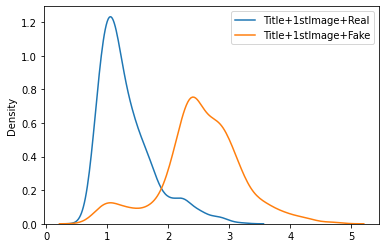

In [70]:
sns.kdeplot(title_im1_t, label="Title+1stImage+Real")
sns.kdeplot(title_im1_f, label="Title+1stImage+Fake")
plt.legend()
plt.show()

## Title is far away from from first image when article is real than the other images peresnt (ie, to get the attention) 

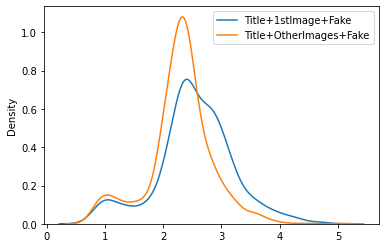

In [71]:
sns.kdeplot(title_im1_f, label="Title+1stImage+Fake")
sns.kdeplot(title_ims_f, label="Title+OtherImages+Fake")
plt.legend()
plt.show()

In [72]:
# compare samples
stat, p = f_oneway(title_im1_f, title_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=134.754, p=0.000
Different distributions (reject H0)


In [73]:
# compare samples
stat, p = mannwhitneyu(title_im1_f, title_ims_f)

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=1120135.000, p=0.000
Different distribution (reject H0)


In [74]:
# compare samples
stat, p = kruskal(title_im1_f, title_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=176.371, p=0.000
Different distributions (reject H0)


## Distance between Image1 and other images is less when sample is real

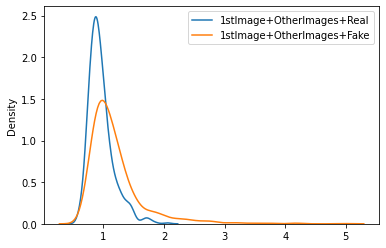

In [86]:
sns.kdeplot(im1_ims_t, label="1stImage+OtherImages+Real")
sns.kdeplot(im1_ims_f, label="1stImage+OtherImages+Fake")
plt.legend()
plt.show()

In [87]:
# compare samples
stat, p = f_oneway(im1_ims_t, im1_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=146.422, p=0.000
Different distributions (reject H0)


In [88]:
# compare samples
stat, p = mannwhitneyu(im1_ims_t, im1_ims_f)

print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distribution (fail to reject H0)')
else:
	print('Different distribution (reject H0)')

Statistics=289195.000, p=0.000
Different distribution (reject H0)


In [89]:
# compare samples
stat, p = kruskal(im1_ims_t, im1_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=195.448, p=0.000
Different distributions (reject H0)


In [63]:
# compare samples
stat, p = f_oneway(text_im1_f, text_ims_f)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Same distributions (fail to reject H0)')
else:
	print('Different distributions (reject H0)')

Statistics=134.754, p=0.000
Different distributions (reject H0)
